<font size = 8 >**OBJETIVOS** </font>


1.   Processar os dados
2.   Selecionar os melhores modelos preditivos
3.   Interpretar resultados

**A fazer**
- XGB e RF
-  combinação de modelos
- avaliar modelos finais
- comentar odds ratio

#Configuração do ambiente

* Instala os pacotes necessários
* Importa as bibliotecas
* Define os objetos que serão utilizados para validação cruzada
* Define funções para exibir o resumo estatístico da validação cruzada

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.9 MB/s eta 0:00:00


In [2]:
!pip install dtreeviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.9 MB/s eta 0:00:00


In [3]:
!pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 2.6 MB/s eta 0:00:00


In [4]:
from IPython.display import HTML
def side_by_side(*dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

In [5]:
import optuna
import dtreeviz
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import numpy as np
from xgboost import XGBClassifier as XGB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from  sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import warnings
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import  roc_auc_score, accuracy_score , balanced_accuracy_score , average_precision_score, recall_score ,precision_score , make_scorer
from sklearn.compose import  ColumnTransformer
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution
from optuna.distributions import IntDistribution
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm

In [6]:
dados = pd.read_csv('https://raw.githubusercontent.com/Gabrieldpll/Hotel-Reservations/main/Hotel_Reservations_feature_engineering%20.csv')

In [7]:
dados['required_car_parking_space'] = dados['required_car_parking_space'].astype('bool')
dados['repeated_guest'] = dados['repeated_guest'].astype('bool')
dados['feriado'] = dados['feriado'].astype('bool')
dados['data'] = pd.to_datetime(dados['data'])

In [8]:
y = dados['booking_status'].map({'Canceled' : 0 ,'Not_Canceled' : 1})
X = dados.drop('booking_status',axis = 1)

In [9]:
X['quarto_gratis'] = X['avg_price_per_room'] == 0

In [10]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True,random_state = 13)
cv_inner  = StratifiedKFold(n_splits=3)


In [11]:
train_index ,test_index = list(skf.split(X,y))[0]
y_test_fold_01 , X_test_fold_01 = y.iloc[test_index] , X.iloc[test_index]
y_train_fold_01 , X_train_fold_01 = y.iloc[train_index] , X.iloc[train_index]

In [12]:
def report(score):
  dicionario = dict()
  for name, key in score.items():
    if name == 'estimator':
       dicionario['hyperparameter'] = [key[i].best_params_ for i in range(10)]
    else:
      dicionario[str(name)] = f"{round(key.mean(),4)} ({round(key.std(),4)})"
  return dicionario


In [13]:
sns.set_style("whitegrid")

In [14]:
import plotly.express as px

# Processamento dos dados


<font size = 5 > **Nessa seção o objeto é criar Pipeline para o pré-processamento dos dados.** </font>

In [15]:
X.columns

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'is_duplicated',
       'duplicated_count', 'data', 'Trimestre', 'feriado', 'quarto_gratis'],
      dtype='object')

In [16]:
# Vamos dividir os atributos para o pré-processamento


numerical_continuos = ['avg_price_per_room','lead_time']
numerical_discrete = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights','duplicated_count', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests']

categorical_nominal = [ 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved','market_segment_type', 'repeated_guest','quarto_gratis','is_duplicated','Trimestre','feriado','arrival_year','arrival_month']



In [17]:
X.filter(numerical_discrete + numerical_continuos, axis = 1).agg(['mean','std']).T.assign(cv = lambda x : x['std']/x['mean'])

mean        std         cv
no_of_adults                            1.890000   0.528702   0.279737
no_of_children                          0.141231   0.462502   3.274797
no_of_weekend_nights                    0.882385   0.887371   1.005651
no_of_week_nights                       2.261923   1.512341   0.668609
duplicated_count                        0.395192   2.685184   6.794627
no_of_previous_cancellations            0.028538   0.408891  14.327723
no_of_previous_bookings_not_canceled    0.213115   2.068243   9.704806
no_of_special_requests                  0.741962   0.815109   1.098587
avg_price_per_room                    105.695838  37.876592   0.358355
lead_time                              66.452846  68.606799   1.032413

In [18]:
for k in numerical_discrete:
  print(k,len(X[k].unique()))

no_of_adults 5
no_of_children 6
no_of_weekend_nights 8
no_of_week_nights 18
duplicated_count 56
no_of_previous_cancellations 9
no_of_previous_bookings_not_canceled 59
no_of_special_requests 6




---


* Note que o coeficiente de variação (CV) é muito diferente para as variáveis numéricas. Isso já é um indicativo da necessidade de padronização das variáveis

* Uma forma de processar os atributos discretos, desde que haja poucos níveis, é por meio de dummy encoding. Esse processamento é especialmente interessante para modelos lineares, já que é uma forma de garantir que haja uma relação linear dos atributos com a resposta. Quando há muitos níveis, é interessante utilizar algum método de discretização para evitar que muitas variáveis dummy sejam criadas

* Numéricos contínuos foram padronizados para ter média 0 e desvio padrão 1. Isso é especialmente importante para evitar problemas numéricos nos otimizadores da regressão logística com penalização e para evitar problemas em algumas distâncias utilizadas no KNN.



---



In [19]:
discrete_not_one_hot = ['no_of_week_nights','duplicated_count','no_of_previous_bookings_not_canceled']
discrete_one_hot = [i for i in numerical_discrete if i not in discrete_not_one_hot]

In [20]:
t = [
    ('num', StandardScaler(), numerical_continuos),
     ('dicrete_1', KBinsDiscretizer(encode = 'onehot-dense', strategy = 'kmeans', n_bins = 4,subsample=None), discrete_not_one_hot),
     ('dicrete_2', OneHotEncoder(sparse_output = False ,handle_unknown = 'infrequent_if_exist' ), discrete_one_hot),
    ('cat',OneHotEncoder( sparse_output = False ,handle_unknown = 'infrequent_if_exist' ),categorical_nominal)
    ]
col_transform = ColumnTransformer(transformers=t, remainder = 'drop')


In [21]:
col_transform

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['avg_price_per_room', 'lead_time']),
                                ('dicrete_1',
                                 KBinsDiscretizer(encode='onehot-dense',
                                                  n_bins=4, strategy='kmeans',
                                                  subsample=None),
                                 ['no_of_week_nights', 'duplicated_count',
                                  'no_of_previous_bookings_not_canceled']),
                                ('dicrete_2',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                               sparse_output=Fals...
                                  'no_of_weekend_nights',
                                  'no_of_previous_cancellations',
                                  'no_of_special_requests']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                               sparse_output=False),
                                 ['type_of_meal_plan',
                                  'required_car_parking_space',
                                  'room_type_reserved', 'market_segment_type',
                                  'repeated_guest', 'quarto_gratis',
                                  'is_duplicated', 'Trimestre', 'feriado',
                                  'arrival_year', 'arrival_month'])])



Portanto, o pipeline para análise, conforme pode ser visto pelo objeto col_transform, é o seguinte:

1. **Padronização**: Ajuste para média 0 e variância 1 para variáveis numéricas.
2. **Codificação One-Hot**: Para variáveis discretas com poucos níveis.
3. **Discretização**: Utilização de K-means para variáveis discretas com muitos níveis.
4. **Codificação One-Hot**: Para variáveis categóricas.



In [22]:
scoring_dict = {'roc_auc' : 'roc_auc',
                 'brier':  'neg_brier_score',
                 'average_precision' : 'average_precision'}

# Modelos interpretáveis

## Knn

* https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
*  https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html


#### Ajuste

In [75]:
knn_model =  Pipeline([
            ('preprocess', col_transform),
            ('knn', KNeighborsClassifier())
        ])

In [76]:
knn_results = cross_validate(knn_model,X,y,cv =skf, scoring = scoring_dict )


In [77]:
report(knn_results)

{'fit_time': '0.2709 (0.0833)',
 'score_time': '1.5383 (0.3932)',
 'test_roc_auc': '0.8454 (0.0066)',
 'test_brier': '-0.1364 (0.0036)',
 'test_average_precision': '0.905 (0.0042)'}

In [78]:
params = {
            "knn__n_neighbors": IntDistribution(1, 50),
            "knn__weights": CategoricalDistribution(['uniform', 'distance']),
            "knn__metric": CategoricalDistribution([ 'l1', 'l2','chebyshev','mahalanobis' ])
        }

study = optuna.create_study(sampler = TPESampler(seed  = 13) , pruner = HyperbandPruner(), direction = 'maximize')

[I 2024-08-02 17:37:22,485] A new study created in memory with name: no-name-e4a78e6a-0ec0-442f-809f-a206e9c3f301


In [79]:
# Realiza a busca no conjutno de validação
# Atenção demora entre 40 - 50 min

search = OptunaSearchCV(estimator =knn_model,
                        param_distributions  = params,
                        cv = cv_inner,
                        scoring='average_precision',
                        n_jobs= -1,
                        random_state = 13,
                        refit = True,
                        study = study,
                        n_trials = 100)



<ipython-input-79-3254e6f25b38>:4: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


In [80]:
# Avaliamos o resultado

scores_knn = cross_validate(search, X, y, scoring= scoring_dict , cv=skf, n_jobs=-1, return_train_score=False, return_estimator = True )

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:110: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


In [81]:
report(scores_knn)

{'fit_time': '877.8708 (81.5998)',
 'score_time': '15.8601 (2.9997)',
 'hyperparameter': [{'knn__n_neighbors': 50,
   'knn__weights': 'uniform',
   'knn__metric': 'l2'},
  {'knn__n_neighbors': 50, 'knn__weights': 'uniform', 'knn__metric': 'l2'},
  {'knn__n_neighbors': 31, 'knn__weights': 'uniform', 'knn__metric': 'l2'},
  {'knn__n_neighbors': 31, 'knn__weights': 'uniform', 'knn__metric': 'l2'},
  {'knn__n_neighbors': 32, 'knn__weights': 'uniform', 'knn__metric': 'l2'},
  {'knn__n_neighbors': 40, 'knn__weights': 'uniform', 'knn__metric': 'l2'},
  {'knn__n_neighbors': 48, 'knn__weights': 'uniform', 'knn__metric': 'l2'},
  {'knn__n_neighbors': 44, 'knn__weights': 'uniform', 'knn__metric': 'l2'},
  {'knn__n_neighbors': 47, 'knn__weights': 'uniform', 'knn__metric': 'l1'},
  {'knn__n_neighbors': 30, 'knn__weights': 'uniform', 'knn__metric': 'l2'}],
 'test_roc_auc': '0.8723 (0.0058)',
 'test_brier': '-0.126 (0.0021)',
 'test_average_precision': '0.937 (0.0038)'}

#### Análise dos resultados

In [82]:
side_by_side( pd.DataFrame.from_dict(report(knn_results), orient = 'index', columns =['resultado']),
             pd.DataFrame.from_dict(report(scores_knn), orient = 'index', columns =['resultado']).drop('hyperparameter', axis = 0)

)

 A tabela acima mostra que a seleção de hiperparâmetros melhorou a capacidade preditiva do KNN. Isso deve-se principalmente à escolha no número de vizinhos (k). Um valor muito baixo para k cria um modelo pouco complexo, enquanto um valor alto cria um modelo mais flexível, mas pode prejudicar a generalização do modelo. A escolha da distância também é importante, no sentido de que pode contribuir para uma melhor representação da matriz de atributos.

#### Interpertação

O KNN pode ser interpretado localmente, a nível modular. Justificamos as predições exibindo os k vizinhos mais próximos de cada exemplo. Será ilustrado esse procedimento para um exemplo predito como não cancelado e um predito como cancelado





In [83]:
scores_knn['estimator'][0].best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_price_per_room',
                                                   'lead_time']),
                                                 ('dicrete_1',
                                                  KBinsDiscretizer(encode='onehot-dense',
                                                                   n_bins=4,
                                                                   strategy='kmeans',
                                                                   subsample=None),
                                                  ['no_of_week_nights',
                                                   'duplicated_count',
                                                   'no_of_previous_bookings_not_canceled']),
                                                 ('dicrete_2',
                                                  OneHotEncoder(handle_unknown='infrequen...
                                                   'no_of_special_requests']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'market_segment_type',
                                                   'repeated_guest',
                                                   'quarto_gratis',
                                                   'is_duplicated', 'Trimestre',
                                                   'feriado', 'arrival_year',
                                                   'arrival_month'])])),
                ('knn', KNeighborsClassifier(metric='l2', n_neighbors=50))])

In [84]:
def get_kneighbors(index,modelo):
    example = X_test_fold_01.iloc[[index], :]

    X_test_standardized = modelo.named_steps['preprocess'].transform(example)

    neighbors_distances, neighbors_indices = modelo.named_steps['knn'].kneighbors(X_test_standardized)

    neighbor_data_frame = X.iloc[neighbors_indices[0], :].copy()

    return neighbor_data_frame, modelo.predict( X_test_fold_01.iloc[[index], :])


In [85]:
vizinhos_2 , predict_2 =  get_kneighbors(2,scores_knn['estimator'][0].best_estimator_)

In [86]:
vizinhos_0 , predict_0 =  get_kneighbors(0,scores_knn['estimator'][0].best_estimator_)

In [87]:
print(predict_2 , predict_0)

[0] [1]


In [88]:
(vizinhos_0['market_segment_type'].value_counts()/len(vizinhos_0))*100

market_segment_type
Online           64.0
Offline          24.0
Corporate         8.0
Complementary     4.0
Name: count, dtype: float64

In [89]:
vizinhos_2['market_segment_type'].value_counts()/len(vizinhos_2)*100

market_segment_type
Online           78.0
Offline          16.0
Corporate         4.0
Complementary     2.0
Name: count, dtype: float64

Note que há uma diferença na proporção de vizinhos que são da classe "online". Os vizinhos mais próximos do exemplo que foi predito como cancelado (vizinho_2) têm 10% a mais de exemplos da classe "online".


In [90]:
vizinhos_0['lead_time'].describe()

count     50.000000
mean      74.700000
std       78.280826
min        0.000000
25%       14.500000
50%       38.500000
75%      119.250000
max      281.000000
Name: lead_time, dtype: float64

In [91]:
vizinhos_2['lead_time'].describe()

count     50.000000
mean      79.360000
std       86.622512
min        0.000000
25%       24.750000
50%       52.500000
75%      104.750000
max      386.000000
Name: lead_time, dtype: float64

Note que a mediana do tempo de espera dos vizinhos mais próximos do exemplo que cancelou é maior.




## Regressão logistica

### Ajuste

In [23]:
from  sklearn.linear_model import LogisticRegression

from optuna.distributions import FloatDistribution

In [24]:
# Grade de valores para o  hiperparâmetro responsável pela penalizacao do modelo logistico
paramslr_regresion = {'lr__C' : FloatDistribution(1e-4, 1000 ,log = True)}


In [25]:
# Modelo logístico incluindo o pre-processamento dos dados
lr_model_ridge =  Pipeline([
            ('preprocess', col_transform),
            ('lr', LogisticRegression(penalty = 'l2', solver ='lbfgs', random_state = 13 ))
        ])


In [26]:
lr_model_ridge

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['avg_price_per_room',
                                                   'lead_time']),
                                                 ('dicrete_1',
                                                  KBinsDiscretizer(encode='onehot-dense',
                                                                   n_bins=4,
                                                                   strategy='kmeans',
                                                                   subsample=None),
                                                  ['no_of_week_nights',
                                                   'duplicated_count',
                                                   'no_of_previous_bookings_not_canceled']),
                                                 ('dicrete_2',
                                                  OneHotEncoder(handle_unknown='infrequen...
                                                   'no_of_special_requests']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['type_of_meal_plan',
                                                   'required_car_parking_space',
                                                   'room_type_reserved',
                                                   'market_segment_type',
                                                   'repeated_guest',
                                                   'quarto_gratis',
                                                   'is_duplicated', 'Trimestre',
                                                   'feriado', 'arrival_year',
                                                   'arrival_month'])])),
                ('lr', LogisticRegression(random_state=13))])

In [27]:
study_lr_model_ridge = optuna.create_study(sampler = TPESampler(seed  = 13) , pruner = HyperbandPruner(), direction = 'maximize')


[I 2024-08-03 22:47:28,270] A new study created in memory with name: no-name-c7105313-a2bd-46f1-a62b-8db440b484c5


In [28]:
search_lr_model_ridge = OptunaSearchCV(estimator =lr_model_ridge,
                        param_distributions  = paramslr_regresion,
                        cv = cv_inner,
                        scoring='average_precision',
                        n_jobs= -1,
                        random_state = 13,
                        refit = True,
                        study = study_lr_model_ridge,
                        n_trials = 100)


<ipython-input-28-13e9df7ca4a8>:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


In [29]:
scores_lr_model_ridge   = cross_validate(search_lr_model_ridge, X, y, scoring= scoring_dict , cv=skf, n_jobs=-1, return_train_score=False, return_estimator = True )

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:110: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


In [30]:
report(scores_lr_model_ridge)

{'fit_time': '285.7235 (14.9681)',
 'score_time': '0.0949 (0.0371)',
 'hyperparameter': [{'lr__C': 0.8755967503933382},
  {'lr__C': 0.6864604104979154},
  {'lr__C': 0.7851290611885177},
  {'lr__C': 0.6246331712519921},
  {'lr__C': 0.5631015859143444},
  {'lr__C': 0.8423513698757431},
  {'lr__C': 0.7843109793923955},
  {'lr__C': 0.5478797738136597},
  {'lr__C': 0.7623164311089261},
  {'lr__C': 0.40696615153108706}],
 'test_roc_auc': '0.8686 (0.0067)',
 'test_brier': '-0.1283 (0.0024)',
 'test_average_precision': '0.9417 (0.0039)'}

### Interpertação dos resultados

#### Coeficientes

In [31]:
def sort_by_abs(x):
  sorted_index = x.abs().sort_values(ascending=False).index
  x = x[sorted_index]
  return x

In [32]:
def limpar_feature_names(x):
  posicao = x.find('__') + 2
  string_nova = x[posicao:]
  return string_nova



In [33]:
def get_coef_from_dict(score_dict,fold):
  '''
  Input : Dicionário gerado pela função cross_validate() , posição do fold
  Output : Série com os coeficientes da regressão
  '''
  feature_names =   score_dict['estimator'][fold].best_estimator_.named_steps['preprocess'].get_feature_names_out()
  feature_names = [limpar_feature_names(feature_names[i]) for i in range(len(feature_names))]
  coef = score_dict['estimator'][fold].best_estimator_.named_steps['lr'].coef_
  return pd.Series(data = coef[0] , index = feature_names)

In [34]:
def get_coef_from_PipeLine(pipeline):
  feature_names =   pipeline.named_steps['preprocess'].get_feature_names_out()
  feature_names = [limpar_feature_names(feature_names[i]) for i in range(len(feature_names))]
  coef = pipeline.named_steps['lr'].coef_
  return pd.Series(data = coef[0] , index = feature_names)


In [35]:
coef = get_coef_from_dict(scores_lr_model_ridge,0)


In [36]:
coef = sort_by_abs(coef)

In [37]:
print(coef[0:5])




no_of_special_requests_3    3.260109
no_of_special_requests_0   -2.962863
arrival_month_1             1.830529
no_of_special_requests_4    1.599406
repeated_guest_True         1.598937
dtype: float64


In [38]:
data_frame_coef = pd.DataFrame(index = coef.index , data = coef.values, columns= ['coeficiente'] )
data_frame_coef['positivo'] = data_frame_coef['coeficiente'] > 0
fig = px.bar(data_frame_coef, x = 'coeficiente' , y = data_frame_coef.index, orientation='h', color = 'positivo')
fig.show()

https://www.smartpricing.it/en/blog/complementary-services-hotel

https://inmachineswetrust.com/posts/drop-first-columns/



<font size = 5 > **Sobre os cofientes da regressão é possível fazer as seguintes observações**



Os coeficientes de regressão podem ser interpretados considerando sua relação com a probabilidade de sucesso. Um coeficiente positivo representa uma contribuição para a probabilidade de sucesso (não cancelamento da reserva), enquanto um coeficiente negativo representa uma contribuição para a probabilidade de fracasso (cancelamento da reserva). Uma vez que as variáveis estão todas padronizadas, também podemos comparar a magnitude dos coeficientes.

In [47]:
coef.filter(['Trimestre_primeiro_trimestre', 'Trimestre_quarto_trimestre','Trimestre_terceiro_trimestre'])

Trimestre_primeiro_trimestre    0.399683
Trimestre_quarto_trimestre      0.190171
Trimestre_terceiro_trimestre    0.040634
dtype: float64


Veja  que o primeiro e o quarto trimestre tiveram um efeito positivo na probabilidade de não cancelamento da reserva

In [53]:
sort_by_abs(coef.filter(['Trimestre_primeiro_trimestre', 'Trimestre_quarto_trimestre','Trimestre_terceiro_trimestre']))

Trimestre_primeiro_trimestre    0.399683
Trimestre_quarto_trimestre      0.190171
Trimestre_terceiro_trimestre    0.040634
dtype: float64

In [52]:
sort_by_abs(
            coef.filter(
                        ['arrival_month_1', 'arrival_month_10',
                        'arrival_month_11', 'arrival_month_12', 'arrival_month_2',
                        'arrival_month_3', 'arrival_month_4', 'arrival_month_5',
                        'arrival_month_6', 'arrival_month_7', 'arrival_month_8',
                        'arrival_month_9']
            ))

arrival_month_1     1.830529
arrival_month_12    0.949964
arrival_month_2    -0.796650
arrival_month_3    -0.634196
arrival_month_11   -0.541277
arrival_month_10   -0.218515
arrival_month_5     0.171241
arrival_month_8    -0.076756
arrival_month_9    -0.067259
arrival_month_6     0.037924
arrival_month_4    -0.017547
arrival_month_7    -0.006970
dtype: float64

É interessante notar que os maiores coeficientes de regressão foram para os clientes que fizeram a reserva em janeiro e dezembro, ambos positivos. Fevereiro, março, outubro e novembro tiveram coeficientes negativos, indicando que as reservas efetuadas nesses meses podem estar associadas a um maior risco de cancelamento

In [55]:
sort_by_abs(coef.filter(['market_segment_type_Aviation',
       'market_segment_type_Complementary', 'market_segment_type_Corporate',
       'market_segment_type_Offline', 'market_segment_type_Online']))

market_segment_type_Offline          1.379422
market_segment_type_Complementary    1.310007
market_segment_type_Online          -1.144186
market_segment_type_Aviation        -0.675774
market_segment_type_Corporate       -0.238981
dtype: float64

Essa é talvez uma das observações mais relevantes geradas ao analisar o resultado da regressão:
- Clientes que realizaram a reserva online podem estar associados a um maior risco de cancelamento (coeficiente negativo), enquanto o contrário é observado para clientes que realizaram a reserva offline.
- Clientes oriundos de reservas do tipo 'complementary' (reservas provenientes de parcerias, brindes, etc.) têm menos propensão ao cancelamento, devido ao seu coeficiente positivo.



In [56]:
sort_by_abs(coef.filter(['no_of_previous_bookings_not_canceled_0.0',
       'no_of_previous_bookings_not_canceled_1.0',
       'no_of_previous_bookings_not_canceled_2.0',
       'no_of_previous_bookings_not_canceled_3.0']))

no_of_previous_bookings_not_canceled_2.0    0.294602
no_of_previous_bookings_not_canceled_3.0    0.174045
no_of_previous_bookings_not_canceled_1.0    0.168850
no_of_previous_bookings_not_canceled_0.0   -0.007008
dtype: float64

O número de reservas prévias que não foram canceladas também é um fator que diminui o risco de cancelamento. Isso é interessante, pois sugere a análise do histórico do cliente, o que pode ser feito de várias maneiras, por meio da criação de novas variáveis.


In [58]:
sort_by_abs(coef.filter(['duplicated_count_0.0', 'duplicated_count_1.0',
       'duplicated_count_2.0', 'duplicated_count_3.0',  'is_duplicated_False', 'is_duplicated_True']))

duplicated_count_0.0    0.919892
duplicated_count_2.0   -0.752480
is_duplicated_False     0.338104
is_duplicated_True      0.292385
duplicated_count_1.0    0.254252
duplicated_count_3.0    0.208825
dtype: float64

In [60]:
sort_by_abs(coef.filter( ['no_of_previous_cancellations_0', 'no_of_previous_cancellations_1',
       'no_of_previous_cancellations_11', 'no_of_previous_cancellations_13',
       'no_of_previous_cancellations_2', 'no_of_previous_cancellations_3',
       'no_of_previous_cancellations_4', 'no_of_previous_cancellations_5',
       'no_of_previous_cancellations_6' ]))

no_of_previous_cancellations_0     1.124934
no_of_previous_cancellations_1    -0.542340
no_of_previous_cancellations_13   -0.386475
no_of_previous_cancellations_2     0.218677
no_of_previous_cancellations_11    0.105528
no_of_previous_cancellations_5     0.053853
no_of_previous_cancellations_4     0.053434
no_of_previous_cancellations_3     0.002414
no_of_previous_cancellations_6     0.000464
dtype: float64

De maneira análoga, um cliente que não teve nenhuma cancelamento anterior tem menor risco de cancelamento associado, enquanto aqueles que têm muitas cancelamentos prévios têm um alto risco de cancelamento.


In [61]:
sort_by_abs(coef.filter( ['no_of_special_requests_0',
       'no_of_special_requests_1', 'no_of_special_requests_2',
       'no_of_special_requests_3', 'no_of_special_requests_4',
       'no_of_special_requests_5' ]))

no_of_special_requests_3    3.260109
no_of_special_requests_0   -2.962863
no_of_special_requests_4    1.599406
no_of_special_requests_1   -1.203029
no_of_special_requests_2   -0.336710
no_of_special_requests_5    0.273576
dtype: float64

Clientes que fizeram poucos pedidos especiais têm um maior risco de cancelamento associado. Enquanto aqueles que fizeram muitos pedidos especiais têm um menor risco associado, especialmente, o coeficiente para 3 pedidos especiais realizados foi um dos maiores observados.


In [62]:
sort_by_abs(coef.filter( [  'quarto_gratis_False', 'quarto_gratis_True']))

quarto_gratis_True     1.288528
quarto_gratis_False   -0.658040
dtype: float64

In [70]:
sort_by_abs(coef.filter( [  'repeated_guest_False', 'repeated_guest_True',]))

repeated_guest_True     1.598937
repeated_guest_False   -0.968448
dtype: float64

Clientes repetidos têm um menor risco de cancelamento, o que é positivo, já que pode indicar uma boa retenção de clientes.


### Resíduos, possíveis outilers e suposições

http://www.sthda.com/english/articles/36-classification-methods-essentials/148-logistic-regression-assumptions-and-diagnostics-in-r/

**A seguir, é feita uma breve nota sobre algumas das suposições do modelo logístico:**

* A variável resposta deve ser binária e independente. Isso é satisfeito em nosso problema com a remoção das observações duplicadas durante a etapa de análise exploratória. Essa é a suposição mais importante; se for violada, outros modelos que levem em conta erros correlacionados devem ser considerados.

* Linearidade entre as variáveis preditoras e a resposta predita (na escala logit). Pode ser verificada em um gráfico de pontos com curva ajustada. Caso essa suposição seja violada, recomenda-se utilizar modelos mais flexíveis, como modelos semi-paramétricos ou modelos aditivos.

* Poucas observações influentes/outliers. Para verificar essa suposição, deve ser conduzida uma análise de influência e de resíduos. A violação dessa suposição pode impactar nas estimativas dos coeficientes e em seus erros padrões.


Uma análise de resíduos será conduzida utilizando os resíduos Randomized Quantile Residual. Mais informações sobre esse resíduo podem ser encontradas  [nesse artigo](https://www.jstor.org/stable/1390802). Não iremos entrar em detalhes nesse trabalho, pois essa discussão desvia dos objetivos específicos deste estudo.


In [114]:
# vetor de probabilidades predita (necessário para os resíduos)
prob_vector = scores_lr_model_ridge['estimator'][0].best_estimator_.predict_proba(X_train_fold_01)[:,1]

In [115]:
# Implementação dos resíduos (veja o artigo)
def sample_riq(y,mu):
  if y == 0:
    residuo = np.random.uniform(low = 0  , high = 1 - mu)
  else:
    residuo = np.random.uniform(low = 1  - mu, high = 1 )
  return residuo

def r_iq(y,mu):
  residuos = [norm.ppf(sample_riq(y[i] , mu[i])) for i in range(len(mu))]
  return residuos

In [116]:
# https://plotly.com/python/v3/normality-test/
from scipy.stats import norm
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [117]:
residuos = r_iq(y_train_fold_01.to_list(),prob_vector)

In [118]:
# Gera um data frame dos resíduos versus tempo

residuos_data_frame = pd.DataFrame( data = list(zip(residuos,dados.filter(X_train_fold_01.index , axis = 0)['data'])),
                                   columns  = ['residuo', 'data']).sort_values(by = 'data')

In [119]:
fig = px.line(residuos_data_frame , x = 'data', y = 'residuo' )
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



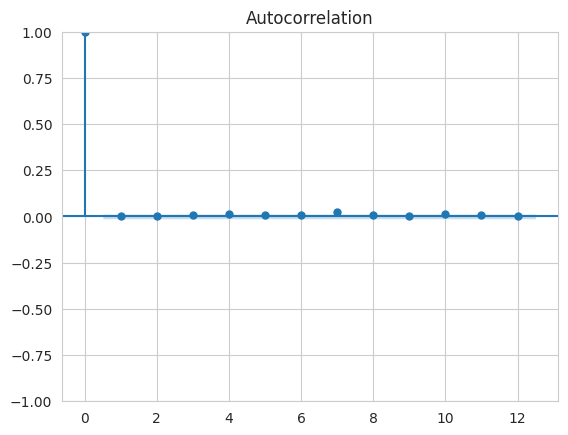

In [120]:
sm.graphics.tsa.plot_acf(residuos_data_frame['residuo'], lags = 12)
plt.show()

In [121]:
print(sm.tsa.stattools.kpss(residuos_data_frame['residuo']))

(0.34037811585055294, 0.1, 27, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


<ipython-input-121-b058792d26d5>:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




https://en.wikipedia.org/wiki/KPSS_test   \\
https://www.statisticshowto.com/kpss-test/

* Como pode ser visto pelos gráficos e pelo teste estatístico, nota-se que não há evidências de autocorrelação nos resíduos. Caso houvesse, teríamos que considerar alguma forma de capturar essa estrutura temporal.



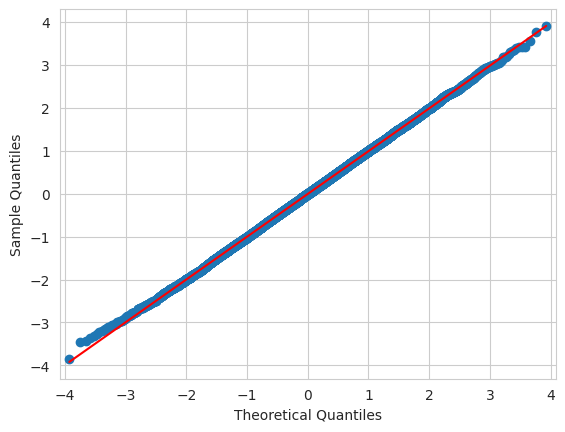

In [122]:
#https://plotly.com/python/v3/normality-test/
import statsmodels.api as sm
qqplot_data = sm.qqplot(np.array(residuos), line='s').gca().lines



O Gráfico informa que algumas observações desviam da linha de referência (vermelha). No entanto, não sabemos como identificar tais pontos, vamos propor uma versão interativa  desse gráfico.

In [123]:
# Necessário identificar as observações.
# Revisar, pode haver um modo mais simples.

identificar_residuos = pd.DataFrame(data = list(zip(residuos,X_train_fold_01.index)), columns = ['residuo', 'index']).sort_values(by = 'residuo')

In [124]:
identificar_residuos.head(5)

residuo  index
16706 -3.855703  18575
22585 -3.452528  25088
23243 -3.435927  25828
18926 -3.356905  21049
11153 -3.305620  12382

In [125]:

fig = go.Figure()

fig.add_trace({
    'type': 'scatter',
    'x': qqplot_data[0].get_xdata(),
    'y': qqplot_data[0].get_ydata(),
    'mode': 'markers',
    'text': identificar_residuos['index'].values,

    'marker': {
        'color': '#19d3f3'
    }
})

fig.add_trace({
    'type': 'scatter',
    'x': qqplot_data[1].get_xdata(),
    'y': qqplot_data[1].get_ydata(),
    'mode': 'lines',

    'line': {
        'color': '#636efa'
    }

})


fig['layout'].update({
    'title': 'Quantile-Quantile Plot',
    'xaxis': {
        'title': 'Theoritical Quantities',
        'zeroline': False
    },
    'yaxis': {
        'title': 'Sample Quantities'
    },
    'showlegend': False,
    'width': 800,
    'height': 700,
})

fig.show()

Os resíduos, supondo um modelo adequado, seguem uma distribuição normal padrão(veja artigo mencionado).Utilizamos o qqplot para verificar se há resíduos que desviam da sua distribuição teórica. Note que os pontos estão, em geral, alinhados, indicando que não há muitos desvios da distribuição normal padrão. É útil dar "zoom" nas caudas do gráfico, geralmente onde têm-se resíduos discrepantes.


#### Linearidade

Em um modelo de regressão logística, os atributos se relacionam de modo linear com a variável resposta na escala logito, que é a probabilidade de sucesso. Essa suposição deve ser verificada; para variáveis contínuas, uma má especificação pode prejudicar tanto a capacidade preditiva quanto a inferencial dos modelos de regressão.

Adaptado de :  


http://www.sthda.com/english/articles/36-classification-methods-essentials/148-logistic-regression-assumptions-and-diagnostics-in-r/

In [126]:
# funcao para criar um dataframe com as variaveis tranformadas
def get_transformed_df_from_pipeline(pipe,X):
  feature_names =   pipe.named_steps['preprocess'].get_feature_names_out()
  transformed =  pipe.named_steps['preprocess'].transform(X)
  df_transformed = pd.DataFrame(data= transformed, columns = feature_names)
  return df_transformed

In [127]:
transformed_matrix_fold_01 = get_transformed_df_from_pipeline(scores_lr_model_ridge['estimator'][0].best_estimator_, X_train_fold_01)

In [128]:
from scipy.special import logit


In [129]:
# como a linearidade é em relacao a escala logit precisamos transformar a prob estimada para logit
transformed_matrix_fold_01['logit']  = logit(prob_vector)

In [130]:
def plot_check_linearity(var_alvo):
    fig = sns.regplot(data=transformed_matrix_fold_01, x='logit', y=var_alvo, ci=0.95,
                     scatter_kws={'alpha': 0.25, 'color': 'grey'}, line_kws={'color': 'blue'}, lowess=True)

    fig.set_title(f"Relação entre logit e {var_alvo}")
    fig.set_xlabel('logit')
    fig.set_ylabel(var_alvo)

    plt.show()


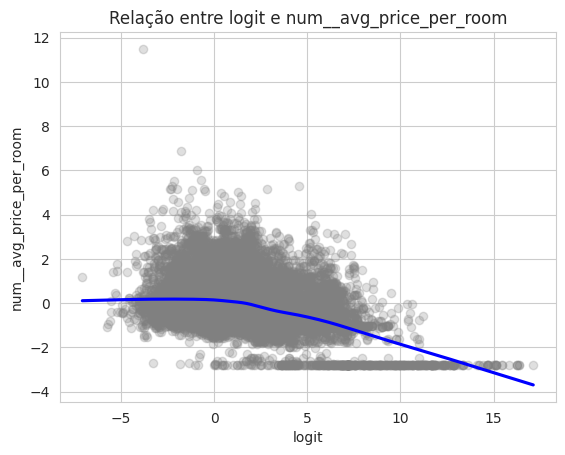

In [131]:
plot_check_linearity('num__avg_price_per_room')

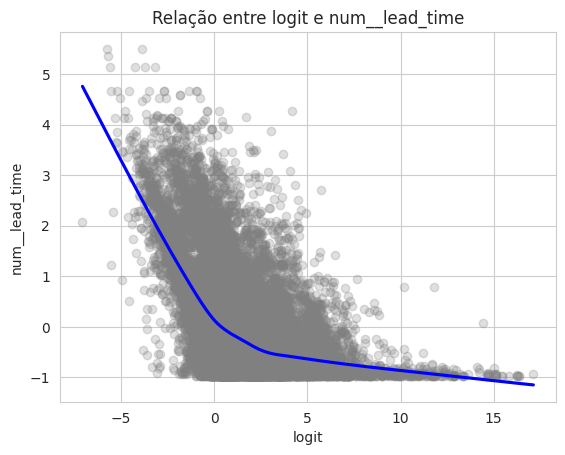

In [132]:
plot_check_linearity('num__lead_time')

* Podemos suspeitar da linearidade dos dois preditores numéricos contínuos. Um próximo passo seria considerar uma extensão do modelo logístico modelando esses preditores via splines, por exemplo. Ou utilizar alguma transformacao para modelar as variaveis preditoras


In [133]:
# Transformação logarítmica é frequentemente utilizada para variáveis positivas
transformed_matrix_fold_01['log_lead_time'] = StandardScaler().fit_transform(
    np.log(X_train_fold_01['lead_time'] + 1).values.reshape(-1, 1)
)


transformed_matrix_fold_01['log_avg_price_per_room'] = StandardScaler().fit_transform(
    np.log(X_train_fold_01['avg_price_per_room'] + 1).values.reshape(-1, 1)
)


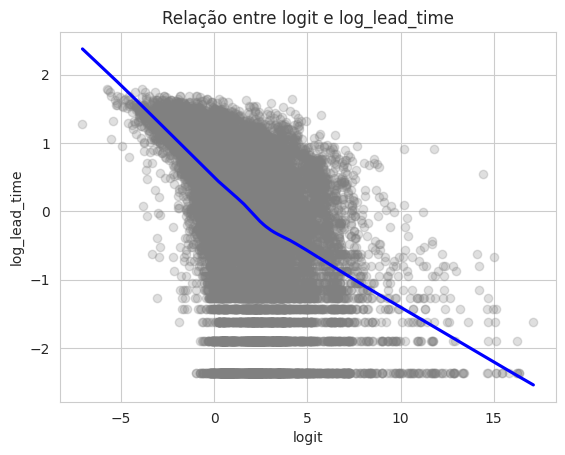

In [134]:
plot_check_linearity('log_lead_time')

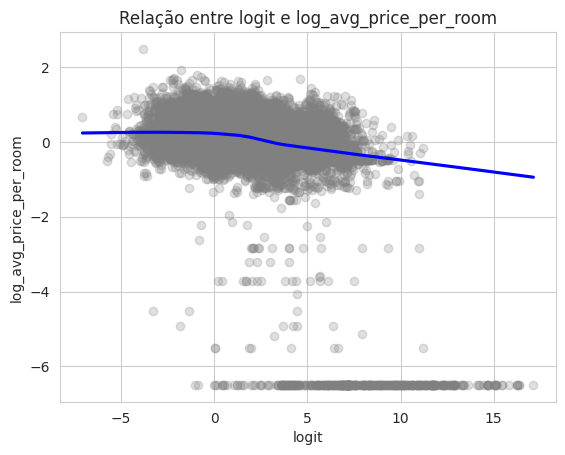

In [135]:
plot_check_linearity('log_avg_price_per_room')

Após as transformações, a relação se torna mais linear, com exceção da variável `avg_price_per_room`, que, como mencionado anteriormente, tem muitos valores iguais a zero.

In [136]:
from sklearn.preprocessing import SplineTransformer,  KBinsDiscretizer

In [137]:
# cria as variaveis transformadas
X['log_lead_time'] = (
    np.log(X['lead_time'] + 1)
)


X['log_avg_price_per_room'] = (
    np.log(X['avg_price_per_room'] + 1)
)


In [138]:
transformed_vars = ['log_avg_price_per_room', 'log_lead_time']
t_transformed = [
    ('num', StandardScaler(), transformed_vars),
     ('dicrete_1', KBinsDiscretizer(encode = 'onehot-dense'), discrete_not_one_hot),
     ('dicrete_2', OneHotEncoder(sparse_output = False ,handle_unknown = 'infrequent_if_exist' ), discrete_one_hot),
    ('cat',OneHotEncoder( sparse_output = False ,handle_unknown = 'infrequent_if_exist' ),categorical_nominal)
    ]
col_transform_transformed_vars = ColumnTransformer(transformers=t_transformed, remainder = 'drop')


In [139]:
col_transform_transformed_vars

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['log_avg_price_per_room', 'log_lead_time']),
                                ('dicrete_1',
                                 KBinsDiscretizer(encode='onehot-dense'),
                                 ['no_of_week_nights', 'duplicated_count',
                                  'no_of_previous_bookings_not_canceled']),
                                ('dicrete_2',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                               sparse_output=False),
                                 ['no_of_adults', 'no_of_children',
                                  'no_of_weekend_nights',
                                  'no_of_previous_cancellations',
                                  'no_of_special_requests']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                               sparse_output=False),
                                 ['type_of_meal_plan',
                                  'required_car_parking_space',
                                  'room_type_reserved', 'market_segment_type',
                                  'repeated_guest', 'quarto_gratis',
                                  'is_duplicated', 'Trimestre', 'feriado',
                                  'arrival_year', 'arrival_month'])])

In [140]:
lr_model_ridge_transformed =  Pipeline([
            ('preprocess', col_transform_transformed_vars),
            ('lr', LogisticRegression(penalty = 'l2',solver ='lbfgs', random_state = 13 ))
        ])


In [141]:
study_lr_model_ridge_transformed = optuna.create_study(sampler = TPESampler(seed  = 13) , pruner = HyperbandPruner(), direction = 'maximize')


[I 2024-08-02 20:02:14,097] A new study created in memory with name: no-name-b9cdbbe3-c8da-40da-b9a0-afa0bf5a4e36


In [142]:
search_lr_model_transformed = OptunaSearchCV(estimator =lr_model_ridge_transformed,
                        param_distributions  = paramslr_regresion,
                        cv = cv_inner,
                        scoring='average_precision',
                        n_jobs= -1,
                        random_state = 13,
                        refit = True,
                        study = study_lr_model_ridge_transformed,
                        n_trials = 100)


<ipython-input-142-79b5086a10eb>:1: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [143]:
scores_lr_model_transformed   = cross_validate(search_lr_model_transformed, X, y, scoring= scoring_dict , cv=skf, n_jobs=-1, return_train_score=False, return_estimator = True )

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:110: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [144]:
report(scores_lr_model_ridge)

{'fit_time': '290.3951 (8.0034)',
 'score_time': '0.1155 (0.0482)',
 'hyperparameter': [{'lr__C': 0.8983361297309763},
  {'lr__C': 0.6715408775256146},
  {'lr__C': 1.7024231358208384},
  {'lr__C': 0.649247009864495},
  {'lr__C': 0.8234622381515826},
  {'lr__C': 1.2995967056443363},
  {'lr__C': 1.4666123090389542},
  {'lr__C': 0.962023532986783},
  {'lr__C': 1.1720452000119166},
  {'lr__C': 0.35299696234358535}],
 'test_roc_auc': '0.8686 (0.0067)',
 'test_brier': '-0.1283 (0.0025)',
 'test_average_precision': '0.9417 (0.004)'}

In [145]:
report(scores_lr_model_transformed)

{'fit_time': '287.9051 (4.3193)',
 'score_time': '0.1276 (0.0583)',
 'hyperparameter': [{'lr__C': 946.5188491648581},
  {'lr__C': 137.70745845737284},
  {'lr__C': 24.425692972858243},
  {'lr__C': 259.35321678952386},
  {'lr__C': 4.681952218591467},
  {'lr__C': 17.84083851783936},
  {'lr__C': 3.729266909740447},
  {'lr__C': 126.96246414463192},
  {'lr__C': 30.926179638562175},
  {'lr__C': 7.759493924212261}],
 'test_roc_auc': '0.8655 (0.0055)',
 'test_brier': '-0.1298 (0.0024)',
 'test_average_precision': '0.94 (0.0029)'}

Outra alternativa é modelar os atributos contínuos usando splines, adicionando uma flexibilidade extra ao modelo de regressão logística, permitindo que a relação entre as variáveis não seja assumida como linear

In [146]:
t_spline = [
    ('num', StandardScaler(), numerical_continuos),
    ('spline', SplineTransformer(knots = 'quantile'), numerical_continuos),
     ('dicrete_1', KBinsDiscretizer(encode = 'onehot-dense'), discrete_not_one_hot),
     ('dicrete_2', OneHotEncoder(sparse_output = False ,handle_unknown = 'infrequent_if_exist' ), discrete_one_hot),
    ('cat',OneHotEncoder( sparse_output = False ,handle_unknown = 'infrequent_if_exist' ),categorical_nominal)
    ]
col_transform_spline = ColumnTransformer(transformers=t_spline, remainder = 'drop')


In [147]:
lr_model_ridge_spline =  Pipeline([
            ('preprocess', col_transform_spline),
            ('lr', LogisticRegression(penalty = 'l2',solver ='lbfgs', random_state = 13 ))
        ])


In [148]:
paramslr_regresion_spline  = {'lr__C': FloatDistribution(high=1000.0, log=True, low=0.0001, step=None),
                              'spline__n_knots' : CategoricalDistribution([3,4,5]),
                              'spline__degree' : CategoricalDistribution([2,3])}



In [149]:
study_lr_model_ridge_spline = optuna.create_study(sampler = TPESampler(seed  = 13) , pruner = HyperbandPruner(), direction = 'maximize')


[I 2024-08-02 20:26:19,923] A new study created in memory with name: no-name-8ed71532-9fb7-4865-9df9-cfaf6f6b4a53


In [150]:
search_lr_model_ridge_spline = OptunaSearchCV(estimator =lr_model_ridge_spline,
                        param_distributions  = paramslr_regresion,
                        cv = cv_inner,
                        scoring='average_precision',
                        n_jobs= -1,
                        random_state = 13,
                        refit = True,
                        study = study_lr_model_ridge_spline,
                        n_trials = 100,
                        verbose = 3)


<ipython-input-150-628385529cf5>:1: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [151]:
report(scores_lr_model_ridge)

{'fit_time': '290.3951 (8.0034)',
 'score_time': '0.1155 (0.0482)',
 'hyperparameter': [{'lr__C': 0.8983361297309763},
  {'lr__C': 0.6715408775256146},
  {'lr__C': 1.7024231358208384},
  {'lr__C': 0.649247009864495},
  {'lr__C': 0.8234622381515826},
  {'lr__C': 1.2995967056443363},
  {'lr__C': 1.4666123090389542},
  {'lr__C': 0.962023532986783},
  {'lr__C': 1.1720452000119166},
  {'lr__C': 0.35299696234358535}],
 'test_roc_auc': '0.8686 (0.0067)',
 'test_brier': '-0.1283 (0.0025)',
 'test_average_precision': '0.9417 (0.004)'}

In [152]:
scores_lr_model_spline   = cross_validate(search_lr_model_ridge_spline, X, y, scoring= scoring_dict , cv=skf, n_jobs=-1, return_train_score=False, return_estimator = True )

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:110: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [153]:
report(scores_lr_model_spline)

{'fit_time': '301.2662 (6.6583)',
 'score_time': '0.0986 (0.0471)',
 'hyperparameter': [{'lr__C': 748.910792784662},
  {'lr__C': 420.1119332587814},
  {'lr__C': 11.295175099375896},
  {'lr__C': 7.5241343910649325},
  {'lr__C': 17.48239312871387},
  {'lr__C': 2.7593033752873968},
  {'lr__C': 4.438461487163052},
  {'lr__C': 12.457975935511604},
  {'lr__C': 23.882331071233168},
  {'lr__C': 9.532357787624361}],
 'test_roc_auc': '0.8738 (0.0053)',
 'test_brier': '-0.1254 (0.0022)',
 'test_average_precision': '0.9437 (0.0031)'}

#### Estimativa intervalar

Referências sobre a estimativa intervalar (do ponto de vista frequentista) e 'post selection inference', em modelos com penalização podem ser encontradas em:

* [Post-Selection Inference](https://www.annualreviews.org/doi/10.1146/annurev-statistics-100421-044639)
* [Statistical Learning with Sparsity](https://hastie.su.domains/StatLearnSparsity/), em especial no capítulo 6.


Aqui está o texto corrigido e um pouco mais fluído:

Alternativamente, podem-se considerar modelos bayesianos com priors de shrinkage, em que a quantificação da incerteza pode ser obtida por meio de intervalos de credibilidade e formas diferentes de penalizar os coeficientes de regressão estão disponíveis . Nessa abordagem, também é possível obter uma distribuição preditiva a posteriori, além de permitir a inclusão de informações sobre novas observações, possibilitando uma espécie de "aprendizado online". Essa abordagem não foi explorada neste trabalho, principalmente devido ao uso intensivo de recursos computacionais que seriam necessários.
\\

**Neste trabalho, por não ser um objetivo primordial, optamos por não apresentar a estimativa intervalar, reconhecendo que os resultados baseados nos métodos mais tradicionais podem estar comprometidos. No entanto, esse estudo pode ser interessante em análises futuras.**

### Comparação dos modelos de regressao e considerações finais

In [154]:
side_by_side(
             pd.DataFrame.from_dict(report(scores_lr_model_ridge), orient = 'index', columns =['resultado']).drop('hyperparameter', axis = 0),
             pd.DataFrame.from_dict(report(scores_lr_model_transformed), orient = 'index', columns =['resultado']).drop('hyperparameter', axis = 0),
             pd.DataFrame.from_dict(report(scores_lr_model_spline), orient = 'index', columns =['resultado']).drop('hyperparameter', axis = 0)
)

escrever

## Modelos Baseados em árvores

* Foi ajustado um modelo de árvore de decisão
* OS hiperparâmetros foram ajustados para obter uma árvore de decisão com maior capacidade preditiva
* Foram indicadas formas de interpretar os resultados


[1] https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680


[2] The Elements of Statistical Learning

### Ajuste

In [155]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
col_transform

In [157]:
model_dct =  Pipeline([
            ('preprocess', col_transform),
            ('dct', DecisionTreeClassifier(random_state = 13))
        ])

In [158]:
# Esse comando ajusta uma árvore de decisão com os hiperparâmetros padrão.

dct_results = cross_validate(model_dct,X,y,cv =skf, scoring = scoring_dict )


In [159]:
report(dct_results)

{'fit_time': '0.3557 (0.0479)',
 'score_time': '0.026 (0.0035)',
 'test_roc_auc': '0.7721 (0.0074)',
 'test_brier': '-0.1899 (0.0051)',
 'test_average_precision': '0.8496 (0.0046)'}

In [218]:
params_dct_weight = {
            "dct__max_depth": IntDistribution(1, 25),
            "dct__criterion": CategoricalDistribution(['gini', 'entropy', 'log_loss']),
            "dct__min_weight_fraction_leaf": FloatDistribution(0,0.1,log = False),
            "dct__min_samples_split" : IntDistribution(1,40,log = False),
            "dct__max_features": CategoricalDistribution(['sqrt', 'log2', None])

        }


params_dct= {
            "dct__max_depth": IntDistribution(1, 25),
            "dct__criterion": CategoricalDistribution(['gini', 'entropy', 'log_loss']),
            "dct__min_samples_leaf": IntDistribution(1,20,log = False),
            "dct__min_samples_split" : IntDistribution(1,40,log = False),
            "dct__max_features": CategoricalDistribution(['sqrt', 'log2', None])

        }

 Os hiperparâmetros serão otimizados considerando o espaço de busca descrito por params_dct. Os hiperparâmetros têm os seguintes significados:
- **max_depth:** Profundidade máxima da árvore. Quanto maior a profundidade, maior a complexidade do modelo. Deve ser ajustado de maneira parcimoniosa, evitando modelos simples (underfitting) e modelos complexos (overfitting).
- **criterion:** É uma função utilizada para decidir se um nó será dividido.
- **min_samples_split:** É o número de exemplos necessários para dividir um nó. Serve para evitar nós puros e pode reduzir a influência de outliers.
- **min_samples_leaf:** É o número de exemplos necessários para formar um nó terminal. Serve para evitar nós puros e pode reduzir a influência de outliers.


In [202]:
study_dct = optuna.create_study(sampler=TPESampler(seed=13), pruner=HyperbandPruner(), direction='maximize')


[I 2024-08-02 23:47:48,531] A new study created in memory with name: no-name-7203e0aa-6690-4c36-95d2-83cacbd99010


In [203]:
search_dct = OptunaSearchCV(estimator=model_dct,
                            param_distributions=params_dct,
                            cv=cv_inner,
                            scoring='average_precision',
                            n_jobs=-1,
                            random_state=13,
                            refit=True,
                            n_trials=300,
                            study=study_dct)

<ipython-input-203-bef0f311f1e3>:1: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [219]:
study_dct_weight = optuna.create_study(sampler=TPESampler(seed=13), pruner=HyperbandPruner(), direction='maximize')


[I 2024-08-03 01:03:42,606] A new study created in memory with name: no-name-f97a8b11-a1e9-4daa-8a9b-c107c4f42d0c


In [220]:
# uma sugestao da documentacao foi utuilizar weight_fraction_leaf, no lugar de min_sample_leafs, pois o primeiro critério é ponderado pela quantidade de exemplos das classes, o que pode ajudar no desbalanceamento dos dados
search_dct_weight = OptunaSearchCV(estimator=model_dct,
                            param_distributions=params_dct_weight,
                            cv=cv_inner,
                            scoring='average_precision',
                            n_jobs=-1,
                            random_state=13,
                            refit=True,
                            n_trials=300,
                            study=study_dct_weight)

<ipython-input-220-1a2b14932613>:2: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [206]:
scores_dct = cross_validate(search_dct, X, y, scoring=scoring_dict, cv=skf, n_jobs=-1, return_train_score=False, return_estimator=True)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:110: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



In [221]:
scores_dct_weight = cross_validate(search_dct_weight, X, y, scoring=scoring_dict, cv=skf, n_jobs=-1, return_train_score=False, return_estimator=True)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:110: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.



### Análise dos resultados

In [230]:
#
side_by_side( pd.DataFrame.from_dict(report(dct_results), orient = 'index', columns =['resultado']),
             pd.DataFrame.from_dict(report(scores_dct), orient = 'index', columns =['resultado']).drop('hyperparameter', axis = 0),
             pd.DataFrame.from_dict(report(scores_dct_weight), orient = 'index', columns =['resultado']).drop('hyperparameter', axis = 0),

)

Note que o procedimento de seleção de hiperparâmetros melhorou significativamente o desempenho do modelo. Isso pode ser atribuído principalmente à escolha cuidadosa do hiperparâmetro max_depth, que possibilita a aprendizagem de modelos mais parcimoniosos, evitando assim o overfitting. O modelo que utilizou o hiperparâmetro weight_fraction_leaf teve um resultado semelhante ao modelo que utilizou o hiperparâmetro min_samples_leaf, mas o Brier score foi pior. Por isso, recomenda-se utilizar o modelo que emprega o min_samples_leaf

In [209]:
pd.DataFrame(report(scores_dct)['hyperparameter'])

dct__max_depth dct__criterion  dct__min_samples_leaf  \
0              11           gini                      1   
1              14        entropy                     20   
2              12       log_loss                     20   
3              14        entropy                     20   
4              12        entropy                     17   
5              14       log_loss                     20   
6              14        entropy                     19   
7              12       log_loss                     17   
8              13        entropy                     19   
9              15        entropy                     20   

   dct__min_samples_split dct__max_features  
0                      40              None  
1                      17              None  
2                      40              None  
3                      19              None  
4                      40              None  
5                      25              None  
6                      10              None  
7                      40              None  
8                       3              None  
9                       9              None


O DataFrame acima exibe os melhores hiperparâmetros para cada fold. É interessante notar que foram consideradas árvores profundas, e os hiperparâmetros `min_samples_leaf` e `min_samples_split` também foram, em geral, altos, implicando em uma árvore assimétrica com poda em alguns dos nós terminais. Isso se deve principalmente ao desbalanceamento dos dados, que pode levar à geração de nós puros, como nós com muitos exemplos da classe minoritária. Embora isso possa ser um bom sinal a priori, pode levar a falhas na generalização do modelo e também o overfit

### Interpertação

Os modelos baseados em árvores são considerados interpretáveis, pois para justificar suas previsões, basta seguir o caminho do nó terminal até o nó raiz. Um gráfico da estrutura da árvore pode ser utitilizado para interpretação dos resultados. No entanto, em árvores profundas, esse gráfico pode se tornar ilegível. Para contornar esse hiato, medidas de importância de atributos podem ser empregadas. Essas medidas quantificam a contribuição global de cada atributo para as previsões.

In [231]:
def plot_tree(score_dict,index):
  '''
    Recebe: Um dicionário contendo os resultados do procedimento de validação cruzada e um índice indicando o fold a ser considerado.
    Retorna:
    - dtreeviz.model (para visualizar a árvore)
    - Matriz de atributos do conjunto de teste, considerando a transformacao do pipeline
    - Vetor resposta do conjunto de teste
    - DataFrame com a importância das features
'''



  # Utilizando o dicionário de scores recuperamos o modelo e os nomes dos atributos
  arvore = scores_dct['estimator'][index].best_estimator_.named_steps['dct']
  feature_names = scores_dct['estimator'][index].best_estimator_.named_steps['preprocess'].get_feature_names_out()
  feature_names = [limpar_feature_names(i) for i in feature_names]

  # Criamos um dataframe de feature importance, ordenando pela maior contribuição
  FI = arvore.feature_importances_
  data_frame_fi = pd.DataFrame(data = FI , index = feature_names, columns = ['feature_importance']).sort_values(by = 'feature_importance', ascending  = False)



  # Recupera os dados utilizados para o treino e teste do modelo
  train_index ,test_index = list(skf.split(X,y))[index]
  y_tain_fold , X_train_fold = y.iloc[train_index] , X.iloc[train_index]
  y_test_fold , X_test_fold = y.iloc[test_index] , X.iloc[test_index]

  # Aplicamos a transformação ao conjunto de treino e teste recuperado. Vale lembrar que esse pipeline já foi ajustado ao conjunto de treino do respectivo fold.
  # Essa etapa é essencial para a função dtreeviz.model(), que não foi projetada para considerar um pipeline.

  X_train_fold_transformed = scores_dct['estimator'][index].best_estimator_.named_steps['preprocess'].transform(X_train_fold)
  X_test_fold_transformed = scores_dct['estimator'][index].best_estimator_.named_steps['preprocess'].transform(X_test_fold)

  viz_model = dtreeviz.model(arvore,
                           X_train=X_train_fold_transformed, y_train=y_tain_fold,
                           feature_names=feature_names,
                           target_name= 'booking_status',
                          class_names= ["Canceled", "Not_Canceled"])


  return viz_model,X_test_fold_transformed,y_test_fold,data_frame_fi

In [232]:
tree_plot,X_test,y_test, feature_importance = plot_tree(scores_dct,0)

In [233]:
feature_importance.head(5)

feature_importance
lead_time                             0.353841
market_segment_type_Online            0.211140
no_of_special_requests_0              0.136185
avg_price_per_room                    0.113901
arrival_month_12                      0.028034

In [234]:
feature_importance = feature_importance.query('feature_importance > 0')


In [235]:
 px.bar(feature_importance['feature_importance'])

O gráfico e a tabela acima permitem a visualização da importância dos atributos para a predição do modelo de árvore de decissão. **Destaca-se que as features mais relevantes incluem 'lead_time', 'no_of_special_requests' e 'market_segment_type_Offline' e avg_price_per_room**


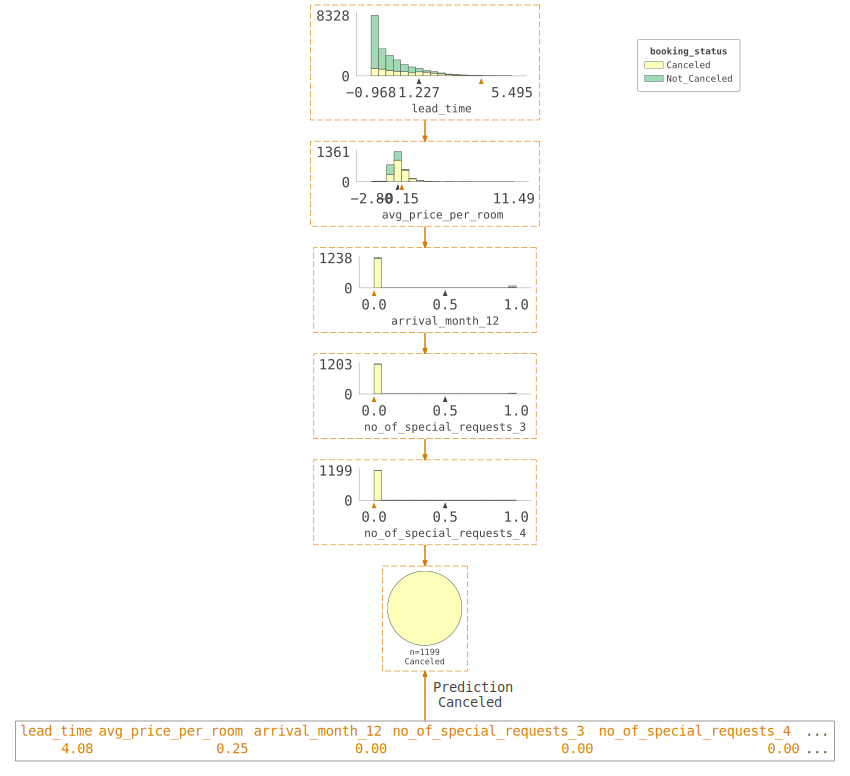

In [236]:

tree_plot.view(x=X_test[2,:],
               show_just_path=True,
               fontname="monospace",
               label_fontsize = 12,
               ticks_fontsize = 15,
               scale  = 1.25)



Este gráfico é empregado para justificar a predição de um exemplo específico. No caso presente, o exemplo foi classificado como cancelado, principalmente devido ao elevado tempo de espera (lead_time). Na representação gráfica, é crucial observar, dentro de cada caixa que representa as partições das árvores:
- O número de observações naquela partição, no canto superior direito.
- A distribuição do atributo, condicionada ao caminho até o nó (o histograma)
- A seta preta que indica a média do conjunto geral.
- A seta amarela que indica a localização do atributo no exemplo analisado.

Ao final, há uma caixa que destaca os atributos utilizados para gerar a predição e seus respectivos valores.


In [237]:
print(tree_plot.explain_prediction_path(x=X_test[2,:]))


-0.15 <= avg_price_per_room 
1.23 <= lead_time 
no_of_special_requests_3 < 0.5
no_of_special_requests_4 < 0.5
arrival_month_12 < 0.5



Também é possível imprimir oa atributos que levaram a decissão

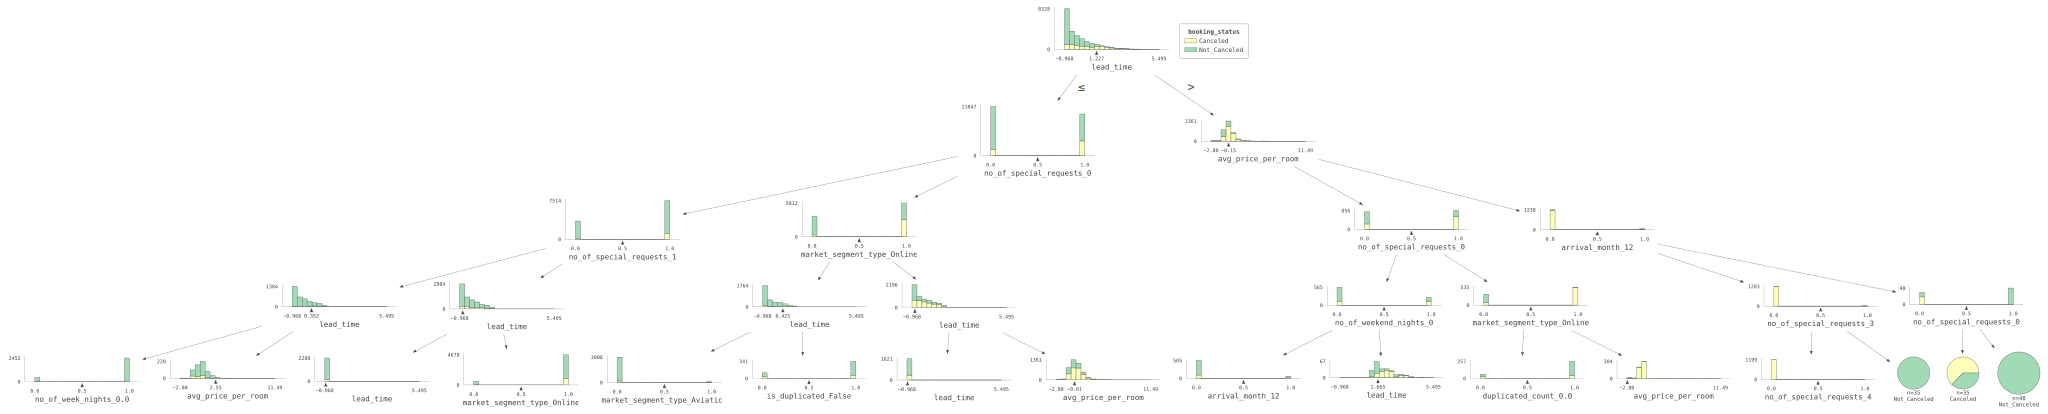

In [239]:
tree_plot.view(
    depth_range_to_display=(0, 4), # Ajuste a profundidade em que a árvore será exibida
    fontname = "monospace",
    #scale = 1.25

)

A árvore pode ser visualizada por cocomleto  ou apenas utilizando alguns de seus níveis. Dada a profundidade considerável da árvore, optamos por exibir somente os primeiros 4 níveis. Destaca-se que a primeira divisão é realizada com base no atributo 'lead_time'.


Note que a interpretação fica mais complicada quanto mais níveis são considerados nas árvores de decisão. No entanto, muitas vezes esses níveis são necessários para capturar a complexidade dos dados, como a não linearidade e as interações. As árvores de decisão são assimétricas devido à influência dos parâmetros min_samples_leaf e min_samples_split. Essa prática é recomendada principalmente porque pode ajudar a evitar o overfitting.


Existem outras estratégias para tornar as árvores mais legíveis para futuras interpretações, como, por exemplo, técnicas de poda da árvore, que visam obter uma árvore menos profunda e/ou larga, mas que mantenha uma boa capacidade preditiva. Além disso, estratégias para capturar regras, explorando a estrutura de regras do tipo 'se... então' das árvores de decisão, também podem ser consideradas. Embora não tenham sido abordadas neste trabalho, essas estratégias podem ser estudadas futuramente



# Modelos baseados em ensembling

# SMOTE , EEN e SMOTEEEN

# Combinação de modelos




# Melhores modelos

# Interpretação de resultados